In [ ]:
from torchvision import transforms
from torch.utils.data import DataLoader
import matplotlib.pyplot as plt
import numpy as np
import cv2

from sklearn.cluster import MiniBatchKMeans
from sklearn.svm import SVC
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import make_pipeline

In [ ]:
import torch
from torchvision import datasets, transforms
from collections import Counter

# 1. Load CIFAR-10 (auto-downloads if needed)
transform = transforms.Compose([
    transforms.Resize((128, 128)),  # Match your expected input size
    transforms.Grayscale(),          # Convert to 1 channel
    transforms.ToTensor()            # Convert to tensor
])

cifar10 = datasets.CIFAR10(root='./data',
                          train=True,
                          download=True,
                          transform=transform)

# 2. Take first 5000 images (already shuffled in PyTorch)
images = []
labels = []
for i, (img, label) in enumerate(cifar10):
    if i >= 5000:
        break
    images.append((img.squeeze().numpy() * 255).astype('uint8'))  # [256,256] uint8
    labels.append(label)

# 3. Analyze distribution
label_counts = Counter(labels)
class_names = ['airplane', 'automobile', 'bird', 'cat', 'deer',
               'dog', 'frog', 'horse', 'ship', 'truck']

print("Image distribution in 5000 samples:")
for label_id, count in sorted(label_counts.items()):
    print(f"{class_names[label_id]}: {count} ({count/50:.1f}%)")

Image distribution in 5000 samples:
airplane: 505 (10.1%)
automobile: 460 (9.2%)
bird: 519 (10.4%)
cat: 486 (9.7%)
deer: 519 (10.4%)
dog: 488 (9.8%)
frog: 519 (10.4%)
horse: 486 (9.7%)
ship: 520 (10.4%)
truck: 498 (10.0%)


In [ ]:
def extract_dog_features(image, contrastThreshold=0.0005, edgeThreshold=30):
    sift = cv2.SIFT_create(contrastThreshold=contrastThreshold, edgeThreshold=edgeThreshold)
    keypoints, descriptors = sift.detectAndCompute(image, None)
    return keypoints, descriptors

In [ ]:
def multi_scale_harris(image, harris_thresh=0.01):
    """
    Harris-Laplace keypoint detector with SIFT descriptors.

    Parameters:
        image (np.ndarray): Grayscale image (uint8 or float32).
        num_scales (int): Number of scales.
        scale_factor (float): Scale increment per octave.
        harris_thresh (float): Threshold to keep strong Harris responses.
        k (float): Harris detector free parameter.

    Returns:
        keypoints (list of cv2.KeyPoint): Final keypoints.
        descriptors (np.ndarray): Corresponding SIFT descriptors.
    """
    if image.dtype != np.float32:
        image = np.float32(image)

    num_scales=6
    scale_factor=1.2
    k=0.04

    harris_responses = []
    blurred_images = []

    # Step 1: Harris detection at multiple scales
    for scale in range(num_scales):
        sigma = scale_factor ** scale
        blur = cv2.GaussianBlur(image, (0, 0), sigmaX=sigma, sigmaY=sigma)
        harris = cv2.cornerHarris(blur, blockSize=2, ksize=3, k=k)
        harris_responses.append(harris)
        blurred_images.append(blur)

    keypoints = []

    # Step 2: Local maxima across scales
    for scale_idx in range(num_scales):
        harris = harris_responses[scale_idx]
        coords = np.argwhere(harris > harris_thresh * harris.max())

        for y, x in coords:
            current_val = harris[y, x]
            is_max = True
            for neighbor_idx in [scale_idx - 1, scale_idx + 1]:
                if 0 <= neighbor_idx < num_scales:
                    neighbor = harris_responses[neighbor_idx]
                    if y < neighbor.shape[0] and x < neighbor.shape[1]:
                        if neighbor[y, x] >= current_val:
                            is_max = False
                            break
            if is_max:
                sigma = scale_factor ** scale_idx
                keypoints.append(cv2.KeyPoint(x=float(x), y=float(y), size=sigma * 5))  # <-- FIXED

    # Compute SIFT descriptors
    sift = cv2.SIFT_create()
    image_for_sift = (image * 255).astype(np.uint8) if image.max() <= 1.0 else image.astype(np.uint8)
    keypoints, descriptors = sift.compute(image_for_sift, keypoints)


    return keypoints, descriptors


In [ ]:
def show_keypoints(image, keypoints, title="Keypoints"):
    image_with_kp = cv2.drawKeypoints(image, keypoints, None, flags=cv2.DRAW_MATCHES_FLAGS_DRAW_RICH_KEYPOINTS)
    plt.figure(figsize=(4, 4))
    plt.imshow(image_with_kp, cmap='gray')
    plt.title(f"{title} ({len(keypoints)} keypoints)")
    plt.axis("off")
    plt.show()

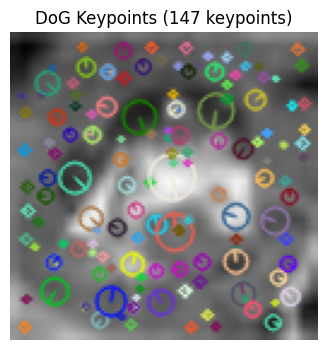

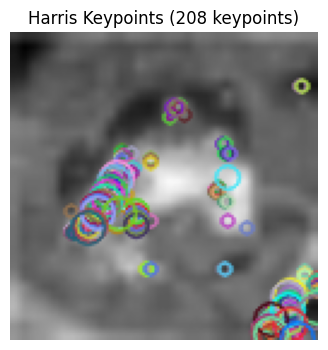

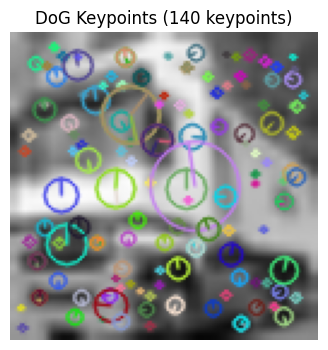

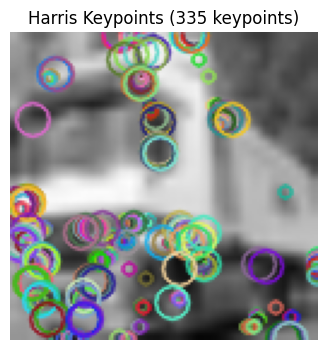

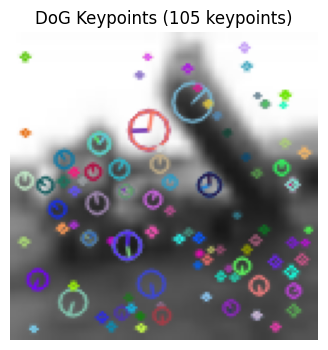

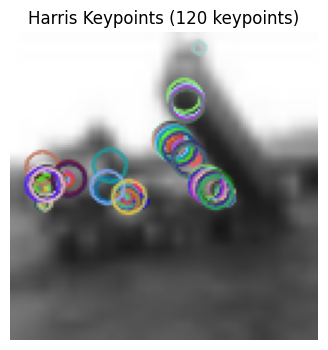

In [ ]:
# Visualize some examples
for i in range(3):
    img = images[i]

    kp1, _ = extract_dog_features(img)
    kp2, _ = multi_scale_harris(img)
    show_keypoints(img, kp1, title=f"DoG Keypoints")
    show_keypoints(img, kp2, title=f"Harris Keypoints")

In [ ]:
import cv2
import numpy as np

def compute_DoG(image, sigma1, sigma2):
    """
    Computes normalized Difference-of-Gaussians (DoG) approximation of LoG.
    Now includes scale normalization for accurate LoG approximation.
    """
    blur1 = cv2.GaussianBlur(image, (0, 0), sigmaX=sigma1)
    blur2 = cv2.GaussianBlur(image, (0, 0), sigmaX=sigma2)

    # Normalization factor: 1/((k-1)*σ₁²), where k = σ₂/σ₁
    k = sigma2 / sigma1
    normalization = 1 / ((k - 1) * sigma1 ** 2)

    return (blur2 - blur1) * normalization  # Normalized DoG ≈ LoG

def harris_laplace_optimized(image,
                            harris_scale_factor=1.4,
                            dog_scale_factor=1.2,
                            num_scales=6,
                            harris_thresh=0.005,
                            dog_thresh=0.0001):
    """
    Optimized Harris-Laplace with:
    - Precomputed Harris/DoG pyramids
    - DoG for fast scale-space extrema
    - Adaptive non-max suppression
    """
    if image.dtype != np.float32:
        image = np.float32(image)

    # =============================================
    # 1. Precompute Harris and DoG pyramids
    # =============================================
    scales = [harris_scale_factor ** i for i in range(num_scales)]
    harris_pyramid = []
    dog_pyramid = []

    for sigma in scales:
        # Harris at current scale
        blurred = cv2.GaussianBlur(image, (0, 0), sigmaX=sigma)
        harris = cv2.cornerHarris(blurred, blockSize=2, ksize=3, k=0.04)
        harris_pyramid.append(harris)

        # DoG for adjacent scales (finer and coarser)
        if sigma > scales[0]:  # Finer scale exists
            dog_finer = compute_DoG(image, sigma/dog_scale_factor, sigma)
        else:
            dog_finer = None

        dog_current = compute_DoG(image, sigma, sigma*dog_scale_factor)
        dog_pyramid.append((dog_finer, dog_current))

    # =============================================
    # 2. Detect scale-space extrema
    # =============================================
    keypoints = []
    for scale_idx, sigma in enumerate(scales):
        harris = harris_pyramid[scale_idx]
        dog_finer, dog_current = dog_pyramid[scale_idx]

        # Get candidate points (Harris thresholding + 3x3 NMS)
        candidates = np.argwhere(harris > harris_thresh * harris.max())
        for y, x in candidates:
            # Spatial NMS: Check 3x3 neighborhood
            patch = harris[max(0,y-1):y+2, max(0,x-1):x+2]
            if harris[y, x] != np.max(patch):
                continue

            # DoG scale-space extremum verification
            val_current = dog_current[y, x]
            val_finer = dog_finer[y, x] if dog_finer is not None else -np.inf
            val_coarser = dog_pyramid[scale_idx+1][1][y, x] if scale_idx < num_scales-1 else -np.inf

            if (val_current > val_finer and
                val_current > val_coarser and
                abs(val_current) > dog_thresh):
                keypoints.append(cv2.KeyPoint(
                    x=float(x),
                    y=float(y),
                    size=sigma * 5,  # size = 5σ
                    response=val_current  # Store DoG strength
                ))

    # =============================================
    # 3. Refine and return keypoints
    # =============================================
    # (Optional) Merge nearby keypoints
    keypoints = list({(int(kp.pt[0]), int(kp.pt[1])): kp for kp in keypoints}.values())
    # Compute SIFT descriptors
    sift = cv2.SIFT_create()
    image_for_sift = (image * 255).astype(np.uint8) if image.max() <= 1.0 else image.astype(np.uint8)
    keypoints, descriptors = sift.compute(image_for_sift, keypoints)

    return keypoints, descriptors

In [ ]:
import cv2
import numpy as np

def combine_features(image, harris_thresh=0.01, sift_contrast_thresh=0.0005, sift_edge_thresh=50):
    """
    Combine SIFT and Harris features, removing duplicates.

    Parameters:
        image: Input grayscale image
        sift_contrast_thresh: SIFT contrast threshold (lower=more features)
        sift_edge_thresh: SIFT edge threshold (higher=more features)
        harris_thresh: Harris threshold (lower=more features)

    Returns:
        combined_kp: Combined keypoints without duplicates
        combined_desc: Corresponding descriptors
    """
    # Extract features from both methods
    sift_kp, sift_desc = extract_dog_features(image, sift_contrast_thresh, sift_edge_thresh)
    harris_kp, harris_desc = multi_scale_harris(image, harris_thresh)

    # If either set is empty, return the other
    if not sift_kp:
        return harris_kp, harris_desc
    if not harris_kp:
        return sift_kp, sift_desc

    # Convert keypoints to numpy arrays for comparison
    sift_points = np.array([(kp.pt[0], kp.pt[1]) for kp in sift_kp])
    harris_points = np.array([(kp.pt[0], kp.pt[1]) for kp in harris_kp])

    # Find duplicates (points within 3 pixels of each other)
    duplicate_mask = np.ones(len(harris_points), dtype=bool)
    radius = 3.0  # pixels

    for i, h_pt in enumerate(harris_points):
        distances = np.sqrt(np.sum((sift_points - h_pt)**2, axis=1))
        if np.any(distances < radius):
            duplicate_mask[i] = False

    # Filter out duplicate Harris points
    filtered_harris_kp = [kp for i, kp in enumerate(harris_kp) if duplicate_mask[i]]
    filtered_harris_desc = harris_desc[duplicate_mask]

    # Combine the features
    combined_kp = list(sift_kp) + filtered_harris_kp
    combined_desc = np.vstack((sift_desc, filtered_harris_desc))

    return combined_kp, combined_desc

In [ ]:
import time

def train_and_evaluate(images, labels, extractor_func, title, n_clusters, harris_thresh, contrastThreshold, edgeThreshold):
    # First pass: Extract descriptors and keep them for both clustering and histogram creation
    start_time = time.time()

    all_descriptors = []
    all_kp_descriptors = []  # Store (kp, desc) pairs for each image
    img_kp_counts = []
    total_kp_count = 0

    for img in images:
        if extractor_func == multi_scale_harris:
            kp, desc = multi_scale_harris(img, harris_thresh=harris_thresh)
        elif extractor_func == harris_laplace_optimized:
            kp, desc = harris_laplace_optimized(img, harris_thresh=harris_thresh)
        elif extractor_func == combine_features:
            kp, desc = combine_features(img, harris_thresh=harris_thresh,
                                      sift_contrast_thresh=contrastThreshold,
                                      sift_edge_thresh=edgeThreshold)
        else:
            kp, desc = extract_dog_features(img, contrastThreshold, edgeThreshold)

        if desc is not None:
            all_descriptors.append(desc)
            all_kp_descriptors.append((kp, desc))
            img_kp_counts.append(len(kp))
            total_kp_count += len(desc)
        else:
            all_kp_descriptors.append((None, None))
            img_kp_counts.append(0)


    all_descriptors = np.vstack(all_descriptors)
    feature_extraction_time = time.time() - start_time

    print(f"{title} Feature Extraction Time: {feature_extraction_time:.2f} seconds")
    print(f"Total Keypoints Detected: {total_kp_count}")

    # KMeans Clustering
    kmeans_start = time.time()
    kmeans = MiniBatchKMeans(n_clusters, batch_size=5000).fit(all_descriptors)
    print(f"Clustering Time: {time.time() - kmeans_start:.2f} seconds")

    # Compute Histograms using stored descriptors
    hist_start = time.time()
    histograms = []
    for kp, desc in all_kp_descriptors:
        if desc is not None:
            words = kmeans.predict(desc)
            hist, _ = np.histogram(words, bins=n_clusters, range=(0, n_clusters))
        else:
            hist = np.zeros(n_clusters)
        histograms.append(hist)
    print(f"Histogram Creation Time: {time.time() - hist_start:.2f} seconds")

    # Prepare data
    X = np.array(histograms)
    y = np.array(labels)

    # Train the SVM Classifier
    clf = make_pipeline(StandardScaler(), SVC())
    split_point = 4000
    X_train = X[:split_point]
    y_train = y[:split_point]
    X_test = X[split_point:]
    y_test = y[split_point:]

    train_start_time = time.time()
    clf.fit(X_train, y_train)
    training_time = time.time() - train_start_time

    print(f"{title} Training Time: {training_time:.2f} seconds")
    acc = clf.score(X_test, y_test)
    print(f"Accuracy: {acc * 100:.2f}%")
    return acc

In [ ]:
train_and_evaluate(images, labels, extract_dog_features, 'DoG', 300, 0, 0.0001, 100)

DoG Feature Extraction Time: 13.18 seconds
Total Keypoints Detected: 346106
Clustering Time: 5.01 seconds
Histogram Creation Time: 1.97 seconds
DoG Training Time: 2.38 seconds
Accuracy: 31.50%


0.315

In [ ]:
train_and_evaluate(images, labels, multi_scale_harris, 'multi_scale_harris', 300, 0.01, 0, 0)

multi_scale_harris Feature Extraction Time: 262.03 seconds
Total Keypoints Detected: 3843383
Clustering Time: 28.26 seconds
Histogram Creation Time: 6.61 seconds
multi_scale_harris Training Time: 2.58 seconds
Accuracy: 49.30%


0.493


=== Testing DoG ===


DoG:   0%|          | 0/4 [00:00<?, ?it/s]

DoG (k=150) Feature Extraction Time: 25.56 seconds
Total Keypoints Detected: 600935
Clustering Time: 3.59 seconds
Histogram Creation Time: 1.78 seconds
DoG (k=150) Training Time: 1.97 seconds


DoG:  25%|██▌       | 1/4 [00:33<01:40, 33.41s/it]

Accuracy: 29.40%
DoG (k=250) Feature Extraction Time: 27.17 seconds
Total Keypoints Detected: 600935
Clustering Time: 7.03 seconds
Histogram Creation Time: 2.03 seconds
DoG (k=250) Training Time: 2.11 seconds


DoG:  50%|█████     | 2/4 [01:12<01:13, 36.67s/it]

Accuracy: 30.70%
DoG (k=350) Feature Extraction Time: 25.57 seconds
Total Keypoints Detected: 600935
Clustering Time: 9.82 seconds
Histogram Creation Time: 2.33 seconds
DoG (k=350) Training Time: 3.22 seconds


DoG:  75%|███████▌  | 3/4 [01:54<00:39, 39.00s/it]

Accuracy: 31.40%
DoG (k=450) Feature Extraction Time: 25.54 seconds
Total Keypoints Detected: 600935
Clustering Time: 10.15 seconds
Histogram Creation Time: 2.61 seconds
DoG (k=450) Training Time: 2.91 seconds


DoG: 100%|██████████| 4/4 [02:36<00:00, 39.13s/it]


Accuracy: 31.40%

=== Testing MultiScaleHarris ===


MultiScaleHarris:   0%|          | 0/4 [00:00<?, ?it/s]

MultiScaleHarris (k=150) Feature Extraction Time: 95.60 seconds
Total Keypoints Detected: 2136785
Clustering Time: 8.54 seconds
Histogram Creation Time: 2.89 seconds
MultiScaleHarris (k=150) Training Time: 1.35 seconds


MultiScaleHarris:  25%|██▌       | 1/4 [01:48<05:26, 108.84s/it]

Accuracy: 40.20%
MultiScaleHarris (k=250) Feature Extraction Time: 96.71 seconds
Total Keypoints Detected: 2136785
Clustering Time: 13.57 seconds
Histogram Creation Time: 3.71 seconds
MultiScaleHarris (k=250) Training Time: 1.89 seconds


MultiScaleHarris:  50%|█████     | 2/4 [03:45<03:46, 113.39s/it]

Accuracy: 42.90%
MultiScaleHarris (k=350) Feature Extraction Time: 95.91 seconds
Total Keypoints Detected: 2136785
Clustering Time: 17.94 seconds
Histogram Creation Time: 4.99 seconds
MultiScaleHarris (k=350) Training Time: 2.40 seconds


MultiScaleHarris:  75%|███████▌  | 3/4 [05:47<01:57, 117.36s/it]

Accuracy: 43.80%
MultiScaleHarris (k=450) Feature Extraction Time: 95.76 seconds
Total Keypoints Detected: 2136785
Clustering Time: 21.76 seconds
Histogram Creation Time: 5.57 seconds
MultiScaleHarris (k=450) Training Time: 2.58 seconds


MultiScaleHarris: 100%|██████████| 4/4 [07:54<00:00, 118.51s/it]

Accuracy: 43.10%


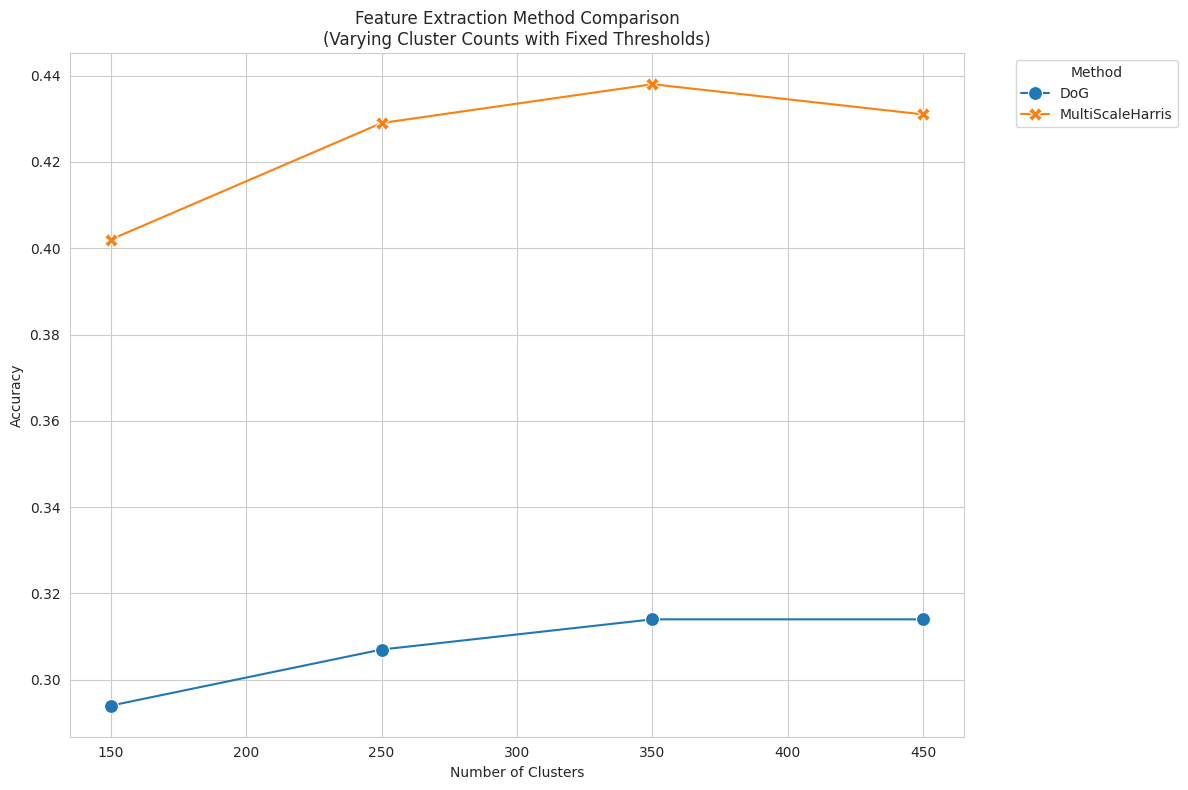


Optimal cluster counts per method:
             method  n_clusters  accuracy
2               DoG         350     0.314
6  MultiScaleHarris         350     0.438


In [ ]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from tqdm import tqdm  # for progress bars

# Configuration for each feature extraction method
methods_config = {
    'DoG': {
        'extractor': extract_dog_features,
        'fixed_params': {
            'harris_thresh': 0,        # Not used for DoG
            'contrastThreshold': 0.001,  # Fixed contrast threshold
            'edgeThreshold': 20        # Fixed edge threshold
        }
    },
    'MultiScaleHarris': {
        'extractor': multi_scale_harris,
        'fixed_params': {
            'harris_thresh': 0.02,     # Fixed Harris threshold
            'contrastThreshold': 0,    # Not used
            'edgeThreshold': 0         # Not used
        }
    }
}

# Cluster values to test
n_clusters_list = [150, 250, 350, 450]

# Store all results
all_results = []

# Test each method
for method_name, config in methods_config.items():
    print(f"\n=== Testing {method_name} ===")
    method_results = []

    for n_clusters in tqdm(n_clusters_list, desc=f"{method_name}"):
        acc = train_and_evaluate(
            images,
            labels,
            config['extractor'],
            f'{method_name} (k={n_clusters})',
            n_clusters=n_clusters,
            harris_thresh=config['fixed_params']['harris_thresh'],
            contrastThreshold=config['fixed_params']['contrastThreshold'],
            edgeThreshold=config['fixed_params']['edgeThreshold']
        )

        method_results.append({
            'method': method_name,
            'n_clusters': n_clusters,
            'accuracy': acc,
            **config['fixed_params']  # Include the fixed params
        })

    all_results.extend(method_results)

# Convert to DataFrame
results_df = pd.DataFrame(all_results)

# Plot results
plt.figure(figsize=(12, 8))
sns.set_style("whitegrid")
g = sns.lineplot(
    data=results_df,
    x='n_clusters',
    y='accuracy',
    hue='method',
    style='method',
    markers=True,
    dashes=False,
    markersize=10
)
plt.title('Feature Extraction Method Comparison\n(Varying Cluster Counts with Fixed Thresholds)')
plt.xlabel('Number of Clusters')
plt.ylabel('Accuracy')
plt.legend(title='Method', bbox_to_anchor=(1.05, 1), loc='upper left')
plt.grid(True)
plt.tight_layout()
plt.savefig('all_methods_cluster_comparison.png', bbox_inches='tight')
plt.show()

# Save results
results_df.to_csv('all_methods_cluster_results.csv', index=False)

# Find optimal cluster count for each method
optimal_clusters = results_df.loc[results_df.groupby('method')['accuracy'].idxmax()]
print("\nOptimal cluster counts per method:")
print(optimal_clusters[['method', 'n_clusters', 'accuracy']])

In [ ]:
train_and_evaluate(images, labels, multi_scale_harris, 'multi_scale_harris', 400, 0.02, 0, 0)

multi_scale_harris Feature Extraction Time: 98.74 seconds
Total Keypoints Detected: 2136785
Clustering Time: 20.45 seconds
Histogram Creation Time: 5.20 seconds
multi_scale_harris Training Time: 2.78 seconds
Accuracy: 42.20%


0.422

In [ ]:
train_and_evaluate(images, labels, multi_scale_harris, 'multi_scale_harri s', 300, 0.02, 0, 0)

multi_scale_harris Feature Extraction Time: 95.34 seconds
Total Keypoints Detected: 2136785
Clustering Time: 16.11 seconds
Histogram Creation Time: 4.19 seconds
multi_scale_harris Training Time: 2.03 seconds
Accuracy: 42.50%


0.425

In [ ]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from itertools import product
# Fixed optimal cluster count
OPTIMAL_CLUSTERS = 350


Testing DoG with contrast=0.005, edge=40
DoG (c=0.005,e=40) Feature Extraction Time: 25.45 seconds
Total Keypoints Detected: 451745
Clustering Time: 6.60 seconds
Histogram Creation Time: 2.45 seconds
DoG (c=0.005,e=40) Training Time: 2.93 seconds
Accuracy: 31.10%

Testing DoG with contrast=0.005, edge=50
DoG (c=0.005,e=50) Feature Extraction Time: 22.54 seconds
Total Keypoints Detected: 452575
Clustering Time: 6.83 seconds
Histogram Creation Time: 2.56 seconds
DoG (c=0.005,e=50) Training Time: 2.84 seconds
Accuracy: 31.70%

Testing DoG with contrast=0.005, edge=60
DoG (c=0.005,e=60) Feature Extraction Time: 22.68 seconds
Total Keypoints Detected: 453001
Clustering Time: 7.19 seconds
Histogram Creation Time: 2.17 seconds
DoG (c=0.005,e=60) Training Time: 2.77 seconds
Accuracy: 30.40%

Testing DoG with contrast=0.001, edge=40
DoG (c=0.001,e=40) Feature Extraction Time: 25.58 seconds
Total Keypoints Detected: 608098
Clustering Time: 9.56 seconds
Histogram Creation Time: 2.40 seconds
DoG 

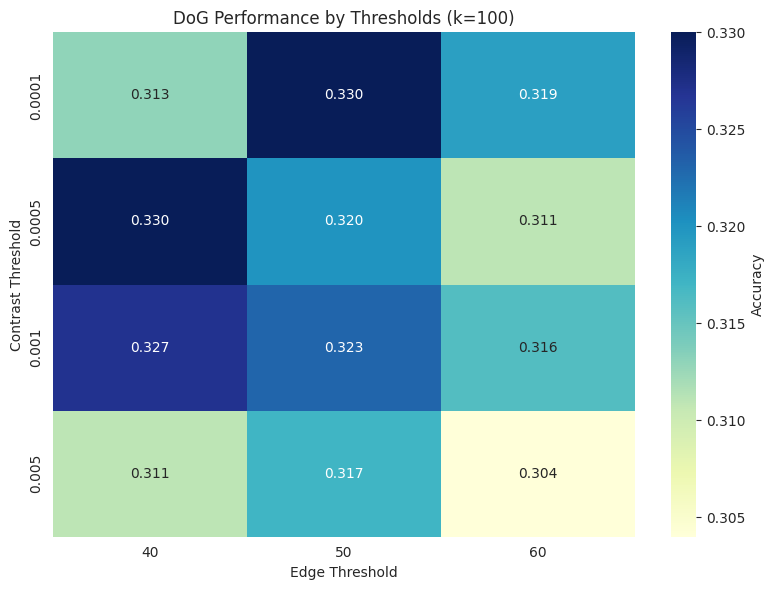


=== Optimal Parameters ===

DoG:
method                   DoG
contrast_threshold    0.0005
edge_threshold            40
accuracy                0.33
Name: 6, dtype: object


In [ ]:
# 2. DoG Threshold Search
contrast_thresholds = [0.005, 0.001, 0.0005, 0.0001]
edge_thresholds = [40, 50, 60]
dog_results = []

for contrast, edge in product(contrast_thresholds, edge_thresholds):
    print(f"\nTesting DoG with contrast={contrast}, edge={edge}")

    acc = train_and_evaluate(
        images,
        labels,
        extract_dog_features,
        f'DoG (c={contrast},e={edge})',
        n_clusters=OPTIMAL_CLUSTERS,
        harris_thresh=0,      # Not used
        contrastThreshold=contrast,
        edgeThreshold=edge
    )

    dog_results.append({
        'method': 'DoG',
        'contrast_threshold': contrast,
        'edge_threshold': edge,
        'accuracy': acc
    })

# Convert to DataFrame
dog_df = pd.DataFrame(dog_results)
dog_df.to_csv('dog_threshold_results.csv', index=False)

# 2. DoG Heatmap

plt.figure(figsize=(8, 6))

heatmap_data = dog_df.pivot(
    index='contrast_threshold',
    columns='edge_threshold',
    values='accuracy'
)
sns.heatmap(
    heatmap_data,
    annot=True,
    fmt=".3f",
    cmap="YlGnBu",
    cbar_kws={'label': 'Accuracy'}
)
plt.title('DoG Performance by Thresholds (k=100)')
plt.xlabel('Edge Threshold')
plt.ylabel('Contrast Threshold')

plt.tight_layout()
plt.savefig('threshold_optimization_results.png')
plt.show()

# Print optimal parameters
print("\n=== Optimal Parameters ===")
print("\nDoG:")
print(dog_df.loc[dog_df['accuracy'].idxmax()])




Testing Multi-Scale Harris with threshold=0.02
MSH (t=0.02) Feature Extraction Time: 95.90 seconds
Total Keypoints Detected: 2136785
Clustering Time: 20.02 seconds
Histogram Creation Time: 4.67 seconds
MSH (t=0.02) Training Time: 2.48 seconds
Accuracy: 44.10%

Testing Multi-Scale Harris with threshold=0.01
MSH (t=0.01) Feature Extraction Time: 140.44 seconds
Total Keypoints Detected: 3204607
Clustering Time: 22.46 seconds
Histogram Creation Time: 6.22 seconds
MSH (t=0.01) Training Time: 2.83 seconds
Accuracy: 45.30%

Testing Multi-Scale Harris with threshold=0.008
MSH (t=0.008) Feature Extraction Time: 158.05 seconds
Total Keypoints Detected: 3593687
Clustering Time: 24.91 seconds
Histogram Creation Time: 6.84 seconds
MSH (t=0.008) Training Time: 2.77 seconds
Accuracy: 46.70%

Testing Multi-Scale Harris with threshold=0.005
MSH (t=0.005) Feature Extraction Time: 197.41 seconds
Total Keypoints Detected: 4470175
Clustering Time: 34.56 seconds
Histogram Creation Time: 8.47 seconds
MSH (t

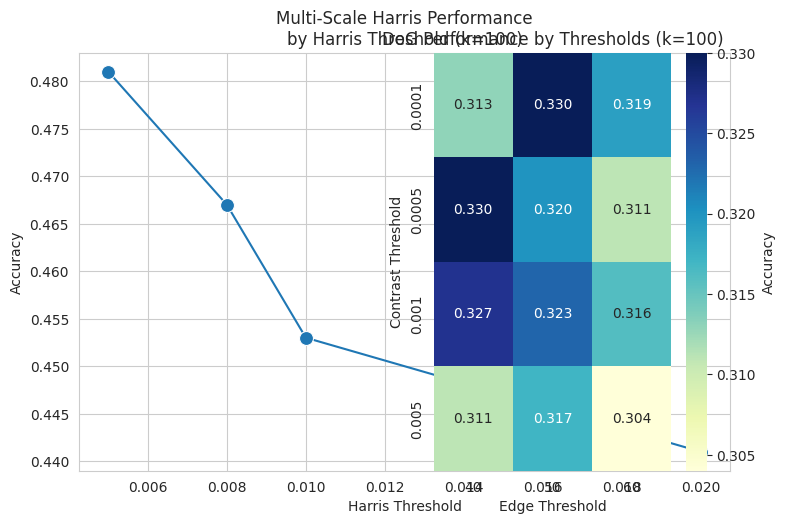


=== Optimal Parameters ===
Multi-Scale Harris:
method              MultiScaleHarris
harris_threshold               0.005
accuracy                       0.481
Name: 3, dtype: object


In [ ]:

# 1. Multi-Scale Harris Threshold Search
harris_thresholds = [0.02, 0.01, 0.008, 0.005]
msh_results = []

for thresh in harris_thresholds:
    print(f"\nTesting Multi-Scale Harris with threshold={thresh}")

    acc = train_and_evaluate(
        images,
        labels,
        multi_scale_harris,
        f'MSH (t={thresh})',
        n_clusters=OPTIMAL_CLUSTERS,
        harris_thresh=thresh,
        contrastThreshold=0,  # Not used
        edgeThreshold=0       # Not used
    )

    msh_results.append({
        'method': 'MultiScaleHarris',
        'harris_threshold': thresh,
        'accuracy': acc
    })

# Convert to DataFrame
msh_df = pd.DataFrame(msh_results)



# Visualization
plt.figure(figsize=(8, 6))

# 1. Multi-Scale Harris Plot
sns.lineplot(
    data=msh_df,
    x='harris_threshold',
    y='accuracy',
    marker='o',
    markersize=10
)
plt.title('Multi-Scale Harris Performance\nby Harris Threshold (k=100)')
plt.xlabel('Harris Threshold')
plt.ylabel('Accuracy')
plt.grid(True)


# Save results
msh_df.to_csv('msh_threshold_results.csv', index=False)


# Print optimal parameters
print("\n=== Optimal Parameters ===")
print("Multi-Scale Harris:")
print(msh_df.loc[msh_df['accuracy'].idxmax()])

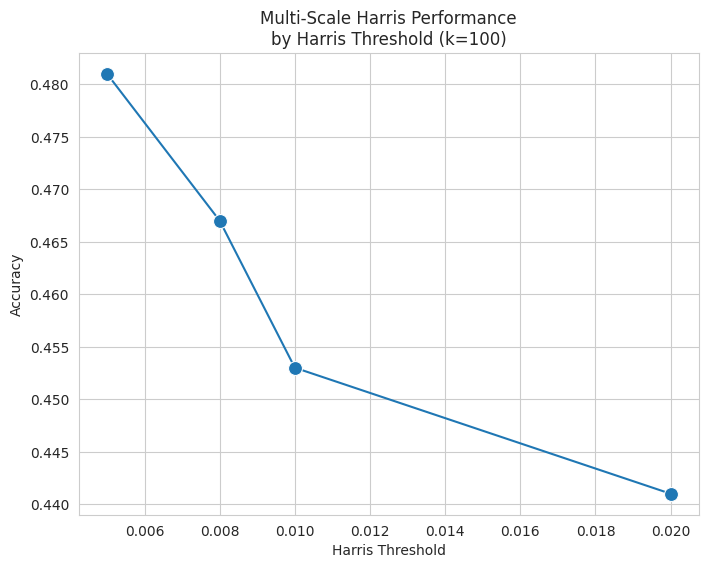

In [ ]:
# Visualization
plt.figure(figsize=(8, 6))

# 1. Multi-Scale Harris Plot
sns.lineplot(
    data=msh_df,
    x='harris_threshold',
    y='accuracy',
    marker='o',
    markersize=10
)
plt.title('Multi-Scale Harris Performance\nby Harris Threshold (k=100)')
plt.xlabel('Harris Threshold')
plt.ylabel('Accuracy')
plt.grid(True)
plt.show()

In [ ]:
train_and_evaluate(images, labels, multi_scale_harris, ' multi_scale_harris', 100, 0.001,0,0)

 multi_scale_harris Feature Extraction Time: 345.78 seconds
Total Keypoints Detected: 7857644
Clustering Time: 21.98 seconds
Histogram Creation Time: 5.67 seconds
 multi_scale_harris Training Time: 0.92 seconds
Accuracy: 47.60%


0.476

In [ ]:
train_and_evaluate(images, labels, combine_features, ' combined_features', 350, 0.005,0.0005,40)

 combined_features Feature Extraction Time: 497.09 seconds
Total Keypoints Detected: 3789154
Clustering Time: 40.80 seconds
Histogram Creation Time: 13.78 seconds
 combined_features Training Time: 5.07 seconds
Accuracy: 49.00%


0.49

In [ ]:
train_and_evaluate(images, labels, harris_laplace_optimized, 'harris_laplace', 350, 0.001,0,0)

harris_laplace Feature Extraction Time: 381.06 seconds
Total Keypoints Detected: 607539
Clustering Time: 12.78 seconds
Histogram Creation Time: 4.31 seconds
harris_laplace Training Time: 5.27 seconds
Accuracy: 46.80%


0.468